In [ ]:
# default_exp core.utils.data

# Data Utility
> Functions for Data Downloading , Loading Images

In [ ]:
#hide
from nbdev.showdoc import *
from nbdev.export import *

In [ ]:
# export
import copy
import types
from collections import UserDict
from typing import *

import os
import cv2
from PIL import Image

import pandas as pd
from sklearn.model_selection import StratifiedKFold
from fastcore.all import ifnone, delegates, Path

from torchvision.datasets.utils import download_and_extract_archive
from torchvision.datasets.folder import IMG_EXTENSIONS

from lightning_cv.core.utils.common import Registry, default_logger

In [ ]:
# hide
# export
# initalize logger
logger = default_logger()

In [ ]:
# export
# copy from : https://github.com/fastai/fastai/blob/master/nbs/04_data.external.ipynb
# a thin wrapper over the original fastai.URLs
class Urls:
    "Global constants for dataset and model URLs."
    LOCAL_PATH = Path.cwd()/"data"
    DOGS = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
    BEES = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

## Downloading

download a data from links in `Urls`

In [ ]:
# export
@delegates(download_and_extract_archive)
def download_data(url: str, data_path: str = None, **kwargs):
    "downloads and extracts the data at `Urls.LOCAL_PATH` if datapath is None"
    data_path = ifnone(data_path, Urls.LOCAL_PATH)
    os.makedirs(Urls.LOCAL_PATH, exist_ok=True)
    download_and_extract_archive(url, Urls.LOCAL_PATH, **kwargs)
    logger.info(f"Data downloaded to {Path(data_path)}")

In [ ]:
#hide
from nbdev.imports import Config as NbdevConfig
import matplotlib.pyplot as plt

nbdev_path = str(NbdevConfig().path("nbs_path")/'data')
nbdev_path

'/Users/ayushman/Desktop/lightning_cv/nbs/data'

In [ ]:
# hide
download_data(Urls.DOGS, data_path=nbdev_path)

Using downloaded and verified file: /Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered.zip
Extracting /Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered.zip to /Users/ayushman/Desktop/lightning_cv/nbs/data
INFO [03/06 01:16:13 __main__]: Data downloaded to /Users/ayushman/Desktop/lightning_cv/nbs/data


In [ ]:
# hide
data  = Path(nbdev_path)/"cats_and_dogs_filtered/train"
image = data/"dogs/dog.0.jpg"

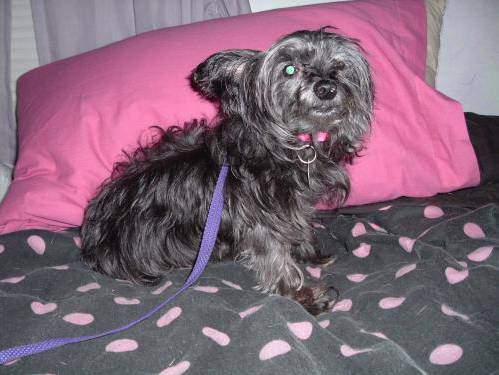

In [ ]:
# hide
Image.open(image)

## Loaders
> Utils for reading Images

In [ ]:
# export
LOADER_REGISTERY = Registry("LOADERS")
LOADER_REGISTERY.__doc__ = "Registery of Loaders, this loaders are used to load in Images"

In [ ]:
show_doc(LOADER_REGISTERY)

<h4 id="LOADERS" class="doc_header"><code>LOADERS</code><a href="" class="source_link" style="float:right">[source]</a></h4>

Registery of Loaders, this loaders are used to load in Images

Load an Image using PIL - 

In [ ]:
# export
@LOADER_REGISTERY.register()
def pil_loader(path) -> Image.Image:
    "loads an image using PIL, mainly used for torchvision transformations"
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")

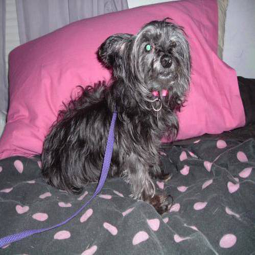

In [ ]:
im = LOADER_REGISTERY.get('pil_loader')(image)
im.resize((255,255))

Load Image using cv2 -

In [ ]:
# export
@LOADER_REGISTERY.register()
def cv2_loader(path):
    "loads an image using cv2, mainly used for albumentations transformations"
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

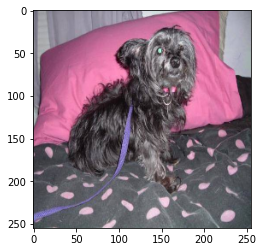

In [ ]:
im = LOADER_REGISTERY.get('cv2_loader')(str(image))
im = cv2.resize(im, (255,255))
plt.imshow(im);

## Utilities for Pandas
> Set of utility functions for working with Image data and pandas

In [ ]:
# export
def folder2df(folder: str, extension: list = None, shuffle: bool = False):
    "parses all the images in a folder into a pandas dataframe."
    extensions = ifnone(extension, IMG_EXTENSIONS)

    image_list  = []
    target_list = []

    for f in os.listdir(folder):
        curr_path = os.path.join(folder, f)
        if os.path.isdir(curr_path):
            for image in os.listdir(curr_path):
                image_path = os.path.join(curr_path, image)
                image_tgt = f
                if image_path.lower().endswith(extensions):
                    image_list.append(image_path)
                    target_list.append(image_tgt)

    logger.info(f"Found {len(image_list)} files belonging to {len(set(target_list))} classes.")
    dataframe = pd.DataFrame()
    dataframe["image_id"] = image_list
    dataframe["target"] = target_list
    if shuffle:
        dataframe = dataframe.sample(frac=1).reset_index(inplace=False, drop=True)
    return dataframe

The folder stucture must be as follows - 
```
folder
|- class1
| |- image1
| |- image2
| |- image3
...
|- class2
| |- image1
| |- image2
| |- image3
|- class2
| |- image1
| |- image2
| |- image3
...
...
```

the `classes` in the folder will be given as `targets` and path of `image` will be stored in `image_id`

In [ ]:
# hide
pd.set_option("display.max_colwidth", None)
df = folder2df(data, shuffle=True)
df.head()

INFO [03/06 01:16:22 __main__]: Found 2000 files belonging to 2 classes.


,image_id,target
0,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/dogs/dog.216.jpg,dogs
1,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/dogs/dog.393.jpg,dogs
2,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/cats/cat.547.jpg,cats
3,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/dogs/dog.798.jpg,dogs
4,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/dogs/dog.846.jpg,dogs


In [ ]:
# export
@delegates(StratifiedKFold)
def stratify_df(df: pd.DataFrame, y: str = None, fold_col: str = None, shuffle: bool = False, **kwargs):
    """makes stratified folds in `df`. The Id of the OOF Validation
    fold will be inserted in `fold_col`. `y` is the name of the column to
    the dependent variable.
    """
    # preserve the original copy of the dataframe
    data = df.copy()
    skf  = StratifiedKFold(**kwargs)
    fold_col = ifnone(fold_col, "kfold")

    ys = data[y]
    data[fold_col] = -1

    for i, (train_index, test_index) in enumerate(skf.split(X=data, y=ys)):
        data.loc[test_index, "kfold"] = i
        
    if shuffle:  data = data.sample(frac=1).reset_index(drop=True)
    return data

In [ ]:
# hide
df1 = stratify_df(df, y="target", shuffle=True)
df1.head()

,image_id,target,kfold
0,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/dogs/dog.888.jpg,dogs,1
1,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/dogs/dog.516.jpg,dogs,3
2,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/cats/cat.126.jpg,cats,2
3,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/cats/cat.859.jpg,cats,1
4,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/cats/cat.124.jpg,cats,1


## DatasetCalalog
> A global dictionary that stores information about the `Datasets` and how to obtain them.

In [ ]:
# export
class _DatasetCatalog(UserDict):
    """
    A global dictionary that stores information about the datasets and how to obtain them.
    It contains a mapping from strings
    (which are names that identify a dataset, e.g. "my_dataset_train")
    to a function which parses the instanitiates the `Dataset` obj.
    
    From - https://github.com/facebookresearch/detectron2/blob/master/detectron2/data/catalog.py
    """

    def register(self, name, func):
        """
        Args:
            name (str): the name that identifies a dataset, e.g. "coco_2014_train".
            func (callable): a callable which takes no arguments and returns a list of dicts.
                It must return the same results if called multiple times.
        """
        assert callable(func), "You must register a function with `DatasetCatalog.register`!"
        assert name not in self, "Dataset '{}' is already registered!".format(name)
        self[name] = func

    def get(self, name):
        """
        Call the registered function and return its results.
        Args:
            name (str): the name that identifies a dataset, e.g. "coco_2014_train".
        Returns:
            list[dict]: dataset annotations.
        """
        try:
            f = self[name]
        except KeyError as e:
            raise KeyError(
                "Dataset '{}' is not registered! Available datasets are: {}".format(
                    name, ", ".join(list(self.keys()))
                )
            ) from e
        return f()

    def list(self) -> List[str]:
        """
        List all registered datasets.
        Returns:
            list[str]
        """
        return list(self.keys())

    def remove(self, name):
        """
        Alias of ``pop``.
        """
        self.pop(name)

    def __str__(self):
        return "DatasetCatalog(registered datasets: {})".format(", ".join(self.keys()))

    __repr__ = __str__

In [ ]:
show_doc(_DatasetCatalog)

<h2 id="_DatasetCatalog" class="doc_header"><code>class</code> <code>_DatasetCatalog</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>_DatasetCatalog</code>(**`dict`**=*`None`*, **\*\*`kwargs`**) :: `UserDict`

A global dictionary that stores information about the datasets and how to obtain them.
It contains a mapping from strings
(which are names that identify a dataset, e.g. "my_dataset_train")
to a function which parses the instanitiates the `Dataset` obj.

From - https://github.com/facebookresearch/detectron2/blob/master/detectron2/data/catalog.py

## Export -

In [ ]:
# hide
notebook2script()

Converted 00_config.ipynb.
Converted 00a_core.common.ipynb.
Converted 00b_core.data.ipynb.
Converted 00c_core.optim.ipynb.
Converted 00d_core.schedules.ipynb.
Converted 00e_core.layers.ipynb.
Converted 01a_classification.data.transforms.ipynb.
Converted 01b_classification.data.datasets.ipynb.
Converted 01c_classification.modelling.body.ipynb.
Converted index.ipynb.
